In [1]:
import numpy as np # linear algebra
import os, sys
import scipy.ndimage
import pickle
from multiprocessing import Pool
from skimage import measure, morphology
import random
import pylab
import skimage.transform
from skimage.feature import canny
from skimage.filters import sobel
from copy import copy
import pydicom as pdcm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow, figure, hist, plot, scatter, colorbar
get_ipython().magic('matplotlib inline')

In [2]:
def flipImage(img):
    leftCount = []
    rightCount = []
    for row in range(img.shape[0]):
        leftCount.append(img[row][0:int(img.shape[1]/2)])
        rightCount.append(img[row][int(img.shape[1]/2):img.shape[1]-1])
    left = np.mean(leftCount)
    right = np.mean(rightCount)
    if right > left:
        img = np.fliplr(img)
    
    return img

In [3]:
def vertBarRemoval(img):
    newIm = np.rot90(img,3)
    row = 0
    while row < newIm.shape[0]:
        if np.mean(newIm[row]) >= 240:
            newIm = newIm[row+1:newIm.shape[0]]
        else:
            row += 1
        
    newIm = skimage.transform.resize(np.rot90(newIm), (224,224))
    return newIm

In [4]:
def cannyCrop(img, canNum):
    canIm = canny(img, canNum) # Do canny transform (Find Which canny # to use) **
    newIm = copy(img) # Coppy to crop at end of function
    
    # Finds all instances of non-false pixels in the canny image
    lineList = []
    for row in range(canIm.shape[0]):
        tempList = []
        for col in range(canIm.shape[1]):
            if canIm[row][col] == True:
                tempList.append(col)
        lineList.append(tempList)
    
    # Finds all instances of pixels part of continuous line from previous lists
    newlineList = []
    i = 0
    while i < len(lineList):
        tempList = []
        for num in lineList[i]:
            if num in lineList[i+1] or num-1 in lineList[i+1]:
                tempList.append(num)

        newlineList.append(tempList)
        i += 1
    
    # Finds first non-empty row to find starting points for lines to select
    rowNum = 0
    for row in newlineList:
        if row != []:
            starterRow = row
            break
            
        rowNum += 1
    
    # Populate dictionary with line starting point and line path
    lineDict = {}
    for el in starterRow:
        lineDict.update({el:[el]})
    
    # Fill line path if within max of 2 to the left of last pixel position
    i = rowNum + 1
    while i < len(newlineList)-1:
        print(i)
        for lineList in list(lineDict.values()):
            print(lineList, newlineList[i], newlineList[i+1])
            if lineList[-1] != -1:
                if lineList[-1]-2 in newlineList[i]:
                    lineList.append(lineList[-1]-2)            
                elif lineList[-1]-1 in newlineList[i]:
                    lineList.append(lineList[-1]-1)            
                elif lineList[-1] in newlineList[i]:
                    lineList.append(lineList[-1])
                elif lineList[-1]+1 in newlineList[i]:
                    lineList.append(lineList[-1]+1)
                elif lineList[-1]+2 in newlineList[i]:
                    lineList.append(lineList[-1]+2)
                elif lineList[-1]-2 in newlineList[i+1]:
                    lineList.append(lineList[-1]-2)            
                elif lineList[-1]-1 in newlineList[i+1]:
                    lineList.append(lineList[-1]-1)            
                elif lineList[-1] in newlineList[i+1]:
                    lineList.append(lineList[-1])
                elif lineList[-1]+1 in newlineList[i+1]:
                    lineList.append(lineList[-1]+1)
                elif lineList[-1]+2 in newlineList[i+1]:
                    lineList.append(lineList[-1]+2)
                else:
                    lineList.append(-1) # end of line condition
        if 0 == len(lineDict):
            break # if all lines are finished, end looping
        i += 1
    
    # Find longest such line (what if i want line that isnt longest??) **
    maxVal = 0
    for key in list(lineDict.keys()):
        if len(lineDict[key]) > maxVal:
            maxKey = key
            maxVal = len(lineDict[key])
        
    # Remove '-1' from end of list
    line = lineDict[maxKey][0:-2]
    # Make line same length as image
    for i in range(canIm.shape[0]):
        if i < rowNum:
            line = [line[0]] + line
        elif i >= len(line):
            line.append(0)
    
    smline = smooth(np.asarray(line))
    smline = smline[round((len(smline)-len(line))/2):]
    line = smline[:img.shape[0]]
    
    # Removes all pixels from left of line
    for row in range(newIm.shape[0]):
        cutOff = line[row]
        for col in range(newIm.shape[1]):
            if col <= cutOff:
                newIm[row][col] = 0
        
        
    return newIm, line

In [5]:
def preProcess(path, canNum):
    im = pdcm.dcmread(image_path)
    im = im.pixel_array
    im = skimage.transform.resize(im, (224,224))
    im = im*255
    
    '''im = plt.imread(path)
    im = skimage.transform.resize(im, (224,224))
    im = im*255'''
    
    finIm = flipImage(im)
    finIm = backgroundRemoval(finIm)
    finIm = vertBarRemoval(finIm)
    
    if 'CC' not in path:
        finIm = cannyCrop(finIm, canNum)
    
    return finIm

In [6]:
image_name = 'Calc-Test_P_00403_RIGHT_MLO'
image_path = 'D:/DDSM_Clean/Calc_Test/' + image_name

In [7]:
im = pdcm.dcmread(image_path)
im = im.pixel_array
im = skimage.transform.resize(im, (224,224))
im = im*255

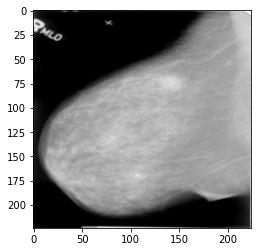

In [197]:
plt.imshow(im, cmap='gray')

In [266]:
def backgroundRemoval(img):
    
    row = 0
    while row < img.shape[0]:
        black = False
        for col in range(img.shape[1]):
            if black == True:
                img[row][col] = 0
            elif img[row][col] == 0 and col > img.shape[1]/3:
                black = True
        
        endPoint = 0
        for col in range(img.shape[1]-1,0,-1):
            if img[row][col] == 0:
                endPoint = col
                break
                        
        if endPoint != 0:
            img[row][endPoint:img.shape[1]] = 0
            row += 1
        else:
            if row < img.shape[0]/2:
                img = img[row+1:img.shape[0]]
            elif row > img.shape[0]/2:
                img = img[0:row-1]
                row += 1
    
    img = skimage.transform.resize(img, (224,224))
    
    return img

In [267]:
def backgroundRemoval(img):
    newIm = copy(img)
    row = 0
    while row < newIm.shape[0]:
        black = False
        for col in range(newIm.shape[1]):
            if black == True:
                newIm[row][col] = 0
            elif newIm[row][col] == 0 and col > newIm.shape[1]/2:
                black = True
        
        endPoint = 0
        for col in range(newIm.shape[1]-1,0,-1):
            if newIm[row][col] == 0:
                endPoint = col
                break
                
        if endPoint != 0:
            newIm[row][endPoint:newIm.shape[1]] = 0
            row += 1
        else:
            row += 1
                        
    newIm = skimage.transform.resize(newIm, (224,224))
    
    return newIm

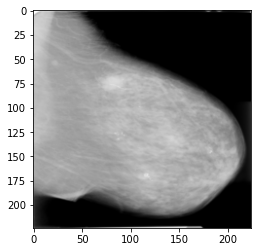

In [230]:
newIm = backgroundRemovalv2(flipImage(im))
plt.imshow(newIm, cmap='gray')

2
[1] [1, 20, 51] [20, 51]
[2] [1, 20, 51] [20, 51]
[20] [1, 20, 51] [20, 51]
[51] [1, 20, 51] [20, 51]
3
[1, 1] [20, 51] [20, 51]
[2, 1] [20, 51] [20, 51]
[20, 20] [20, 51] [20, 51]
[51, 51] [20, 51] [20, 51]
4
[1, 1, -1] [20, 51] [19, 51]
[2, 1, -1] [20, 51] [19, 51]
[20, 20, 20] [20, 51] [19, 51]
[51, 51, 51] [20, 51] [19, 51]
5
[1, 1, -1] [19, 51] [19, 51]
[2, 1, -1] [19, 51] [19, 51]
[20, 20, 20, 20] [19, 51] [19, 51]
[51, 51, 51, 51] [19, 51] [19, 51]
6
[1, 1, -1] [19, 51] [19, 52]
[2, 1, -1] [19, 51] [19, 52]
[20, 20, 20, 20, 19] [19, 51] [19, 52]
[51, 51, 51, 51, 51] [19, 51] [19, 52]
7
[1, 1, -1] [19, 52] [19, 52]
[2, 1, -1] [19, 52] [19, 52]
[20, 20, 20, 20, 19, 19] [19, 52] [19, 52]
[51, 51, 51, 51, 51, 51] [19, 52] [19, 52]
8
[1, 1, -1] [19, 52] [19]
[2, 1, -1] [19, 52] [19]
[20, 20, 20, 20, 19, 19, 19] [19, 52] [19]
[51, 51, 51, 51, 51, 51, 52] [19, 52] [19]
9
[1, 1, -1] [19] [18, 53]
[2, 1, -1] [19] [18, 53]
[20, 20, 20, 20, 19, 19, 19, 19] [19] [18, 53]
[51, 51, 51, 51, 

[1, 1, -1] [1, 17, 94, 133, 134, 212] [1, 18, 25, 26, 27, 34, 94, 182, 212]
[2, 1, -1] [1, 17, 94, 133, 134, 212] [1, 18, 25, 26, 27, 34, 94, 182, 212]
[20, 20, 20, 20, 19, 19, 19, 19, 19, 18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 15, 15, 15, 15, 14, 14, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 17, 16, 16, 15, 14, 13, 12, 11, 9, 8, 6, 4, 2, 1, 1, 1, 1, -1] [1, 17, 94, 133, 134, 212] [1, 18, 25, 26, 27, 34, 94, 182, 212]
[51, 51, 51, 51, 51, 51, 52, 52, 53, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 62, 63, 64, 65, 65, 66, 67, 68, 69, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, -1] [1, 17, 94, 133, 134, 212] [1, 18, 25, 26, 27, 34, 94, 182, 212]
1

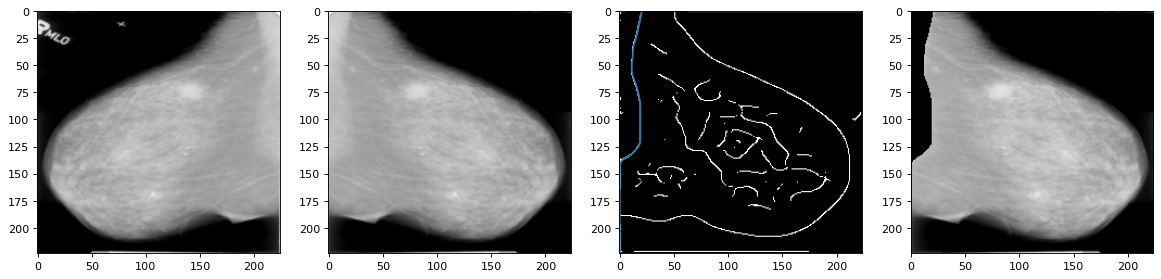

In [284]:
'''for row in range(im.shape[0]):
    for col in range(im.shape[1]):
        if im[row][col] < 5:
            im[row][col] = 0'''

newIm = vertBarRemoval(backgroundRemoval(flipImage(im)))

canNum = 6
canIm = canny(newIm,canNum)
cropIm, line = cannyCrop(newIm, canNum)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k') 
plt.subplot(1,4,1)
plt.imshow(im, cmap='gray')
plt.subplot(1,4,2)
plt.imshow(newIm, cmap='gray')
plt.subplot(1,4,3)
plt.imshow(canIm, cmap='gray')
plt.plot(line, list(range(len(line))))
plt.subplot(1,4,4)
plt.imshow(cropIm, cmap='gray')


In [113]:
saveDir = 'C:/Users/Noah/Documents/DDSM_Data/CropTest/'

dirName = 'C:/Users/Noah/Documents/DDSM_Data/DDSM_Full/Test/Calc_Mal/'
for pathName in os.listdir(dirName):
    img = preProcess(dirName + pathName, 6)
    plt.imsave(saveDir + pathName, img, cmap="gray")

IndexError: list index out of range

In [141]:
import numpy

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

In [129]:
y = smooth(test)

In [130]:
y = y[round((len(y)-len(test))/2):]

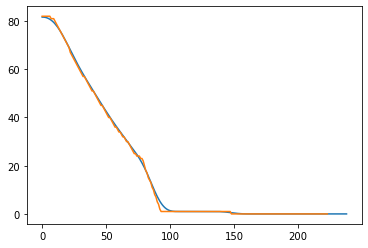

In [131]:
plt.plot(y)
plt.plot(test)

In [132]:
len(y)-len(test)

15

In [211]:
list(range(224))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [234]:
test = [[], [1, 2, 20, 51], [1, 20, 51], [20, 51], [20, 51], [19, 51], [19, 51], [19, 52], [19, 52], [19], [18, 53], [18, 54], [18, 55], [18, 56], [17, 57], [17, 58], [17, 59], [17, 60], [17, 61], [16], [16, 62], [16, 63], [16, 64], [15, 65], [15, 65], [15, 66], [15, 67], [14, 68], [14], [13, 14, 69], [13, 70], [13, 30, 71], [13, 32, 72], [12, 33, 73], [12, 74], [12, 36, 75], [12, 37, 76], [12, 39, 77], [12, 40, 78], [12, 43], [12, 81], [12, 82], [12], [12, 85], [12], [11, 12], [11, 90], [11, 92], [11], [11], [11], [11, 101], [11], [11, 106], [11], [11], [11, 114], [11], [11], [38, 121], [12, 39, 123], [12, 41, 125], [43], [13], [13, 83], [49, 81, 134], [14, 78, 136], [14, 75, 76], [15, 73, 74], [15, 54, 72, 73, 143], [71, 72, 145], [16, 70, 71], [16, 69, 70], [16, 70], [70], [17, 93, 155], [17, 92, 157], [17, 72, 92, 159], [92, 93, 161], [18, 50, 73, 92, 93, 163], [1, 18, 50, 74, 91, 92, 165], [1, 18, 50, 75, 90, 167], [18, 51, 87], [39, 51, 170], [19, 52, 172], [19, 53, 173], [19, 54, 175], [19, 176], [19, 55, 112, 113, 114, 178], [19, 55, 112, 113, 179], [19, 55], [19, 55, 113, 182], [19, 54, 183], [1, 19], [1, 3, 19, 83, 113, 186, 222], [19, 53, 83, 113, 139, 187, 222], [19, 53, 83, 112, 221, 222], [19, 53, 83, 113, 190, 220, 221], [19, 52, 82, 83, 114, 191, 219, 220], [19, 53, 82, 115, 192, 218, 219], [19, 53, 81, 82, 118, 193, 217, 218], [19, 54, 80, 81, 195], [19, 54, 80, 196], [19, 55, 132, 197], [19, 56, 135, 198], [19, 79, 136, 199], [19, 57, 79, 200], [19, 79, 139], [19, 58, 79, 140, 168, 201], [19, 58, 78, 140, 167, 168, 202], [19, 78, 104, 105, 141, 167, 203], [19, 59, 78, 99, 104, 141, 167, 204], [19, 59, 77, 98, 99, 142, 204], [19, 76, 77, 98, 142, 205], [19, 60, 76, 98, 143], [19, 75, 76, 98, 143, 206], [19, 61, 75, 98, 143, 207], [19, 61, 74, 97, 127, 128, 129, 144, 207], [19, 61, 74, 97, 127, 128, 129, 144, 208], [19, 61, 97, 127, 128, 145, 208], [19, 61, 96, 97, 110, 126, 127, 145], [19, 61, 95, 96, 111, 126, 127, 146, 209], [19, 61, 94, 95, 125, 147, 209], [18, 61, 93, 94, 123, 124, 148], [18, 62, 91, 92, 93, 122, 123, 149, 210], [17, 62, 121, 122, 150, 210], [16, 17, 63, 120, 121, 151], [16, 65, 119, 120, 152, 211], [15, 67, 118, 119, 153, 211], [14, 77, 118, 131, 154, 211], [13, 14, 98, 117, 118, 132, 155, 211], [12, 13, 80, 116, 117, 132, 155, 211], [11, 12, 80, 99, 115, 132, 156], [9, 10, 81, 113, 114, 133, 156, 212], [8, 9, 82, 112, 113, 134, 155, 156, 212], [6, 7, 82, 111, 112, 135, 155, 212], [4, 5, 83, 135, 154, 155, 212], [1, 2, 84, 136, 154, 212], [1, 84, 137, 153, 212], [1, 85, 138, 153, 212], [1, 86, 153, 212], [1, 28, 87, 139, 153, 212], [28, 88, 212], [89, 212], [1, 40, 51, 90, 141, 212], [1, 37, 54, 91, 154, 155, 212], [1, 36, 56, 57, 92, 152, 212], [1, 58, 93, 176, 212], [1, 17, 59, 94, 135, 212], [1, 17, 94, 133, 134, 212], [1, 18, 25, 26, 27, 34, 94, 182, 212], [1, 33, 34, 94, 183, 212], [1, 35, 48, 94, 212], [1, 35, 48, 94, 190, 212], [1, 36, 47, 62, 94, 190, 212], [1, 36, 61, 62, 94, 190, 191, 212], [1, 37, 60, 61, 189, 190, 191, 212], [1, 38, 95, 189, 190, 212], [1, 20, 188, 189, 211], [1, 19, 188, 211], [1, 18, 55, 150, 187, 188, 211], [1, 16, 17, 55, 186, 187, 210], [1, 56, 115, 120, 185, 186, 210], [1, 56, 109, 122, 147, 184, 185, 209, 210], [107, 108, 124, 146, 147, 182, 183, 209], [107, 125, 180, 208, 209], [106, 126, 178, 208], [106, 127, 168, 207, 208], [106, 127, 164, 207], [106, 127, 162, 206], [35, 40, 105, 127, 160, 161, 205, 206], [159, 160, 204, 205], [142, 158, 159, 204], [142, 158, 203, 204], [158, 202, 203], [143, 201, 202], [200, 201], [199, 200], [198, 199], [121, 124, 125, 126, 127, 197, 198], [196, 197], [195, 196], [194, 195], [193, 194], [192], [190, 191], [189, 190], [188, 189], [1, 187, 188], [11, 57, 186, 187], [16, 53, 185, 186], [50, 51, 184, 185], [47, 48, 183, 184], [44, 182], [78, 180, 181], [80, 179, 180], [178], [1, 176, 177], [1, 175], [1, 88, 173, 174], [1, 171, 172], [1, 94, 169, 170], [167, 168], [165], [106, 162, 163], [1, 159, 160], [1, 156], [1, 150], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [], []]

In [264]:
test[-3]

[1]

In [ ]:
test